## Imports

In [62]:
import pandas as pd
import seaborn as sns

import re
import nltk
import scipy
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report

## Feature Extraction

In [63]:
import pandas as pd

def process(df):
    df['NotHelpfulNumerator'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df['NotHelpfulNumerator'] = df['NotHelpfulNumerator'].fillna(0)
    return df

trainingSet = pd.read_csv("./data/train.csv")
train_processed = process(trainingSet)

submissionSet = pd.read_csv("./data/test.csv")

testX = pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

trainX =  train_processed[train_processed['Score'].notnull()]

testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

## Exploration

In [64]:
trainingSet = pd.read_csv("./data/X_train.csv")
testingSet = pd.read_csv("./data/X_test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

train.csv shape is  (122283, 10)
test.csv shape is  (17470, 10)


Text(0.5, 1.0, 'Mean Not Helpful Numerator per Score')

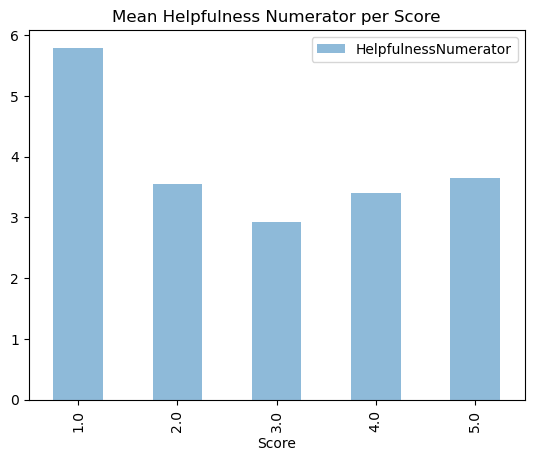

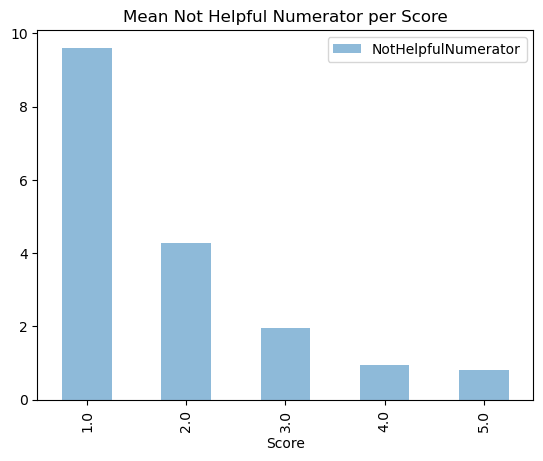

In [65]:
trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")

trainingSet[['Score', 'NotHelpfulNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Not Helpful Numerator per Score")

## Cleaning Data

In [66]:
def preprocess_text_data(texts):
    processed_texts = []
    for text in texts:
        cleaned_text = removeSpecialChar(text)
        cleaned_text = toLowerCase(cleaned_text)
        cleaned_text = removeStopWords(cleaned_text)
        processed_texts.append(cleaned_text)
    return processed_texts

def toLowerCase(text):
    clean_text = " ".join(text.lower().split())  
    return clean_text

stop_words = ['a', 'an', 'the', 'and', 'this', 'that']

def removeStopWords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(filtered_words)
    return processed_text

def removeSpecialChar(text):
    if (type(text) == str):
        clean_text = re.sub("[^a-zA-Z]", " ", text)
    else:
        clean_text = "it was okay"
    return clean_text

In [67]:
train = pd.read_csv("./data/X_train.csv")
test = pd.read_csv("./data/X_test.csv")

OHE = OneHotEncoder(sparse=True, handle_unknown='ignore')
IDs = OHE.fit_transform(train[['ProductId', 'UserId']])
IDs_test = OHE.transform(test[['ProductId', 'UserId']])

scaler = StandardScaler()
num_features = ['HelpfulnessNumerator', 'NotHelpfulNumerator', 'Time']
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

train['Text'].fillna('', inplace=True)
train['Summary'].fillna('', inplace=True)
test['Text'].fillna('', inplace=True)
test['Summary'].fillna('', inplace=True)

Xs_train_processed = preprocess_text_data(train['Summary'])
Xt_train_processed = preprocess_text_data(train['Text'])

Xs_test_processed = preprocess_text_data(test['Summary'])
Xt_test_processed = preprocess_text_data(test['Text'])

text_vectorizer = TfidfVectorizer(input='content')
summary_vectorizer = TfidfVectorizer(input='content')

text_matrix = text_vectorizer.fit_transform(Xt_train_processed)
summary_matrix = summary_vectorizer.fit_transform(Xs_train_processed )

text_matrix_test = text_vectorizer.transform(Xt_test_processed)
summary_matrix_test = summary_vectorizer.transform(Xs_test_processed)

In [68]:
numerical = train[num_features]
numerical_test = test[num_features]

X_train = hstack([text_matrix, summary_matrix, numerical, IDs])
y_train = train['Score']
X_test = hstack([text_matrix_test, summary_matrix_test, numerical_test, IDs_test])
y_test = test['Score']

## Creating Model

## Linear SVC

In [69]:
model = Pipeline([
    ('SVC', SVC(kernel='linear', C=0.2, probability=True))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

Accuracy on testing set =  0.9606895480156685
RMSE on testing set =  0.0657573006877489


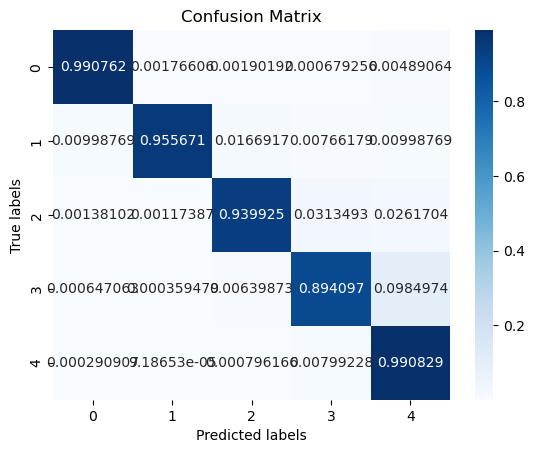

In [71]:
y_pred = model.predict(X_train)
print("Accuracy on testing set = ", accuracy_score(y_train,y_pred))
print("RMSE on testing set = ", mean_squared_error(y_train,y_pred))

ax= plt.subplot()
cm=confusion_matrix(y_train,y_pred,normalize='true')
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Blues');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

In [11]:
Y_test_predictions = model.predict(X_test)
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = Y_test_predictions
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submissionlinsvc.csv", index=False)

## Logistic Regression

In [72]:
model2 = Pipeline([('logistic_regression', LogisticRegression(random_state=0, max_iter=1000))])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_train)

Accuracy on testing set =  0.9406458788220766
RMSE on testing set =  0.13679742891489413


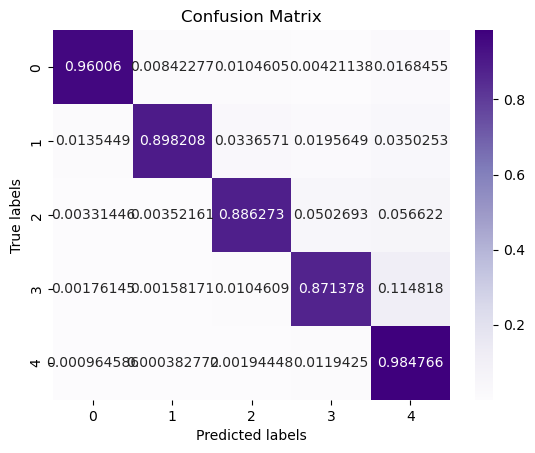

In [73]:
print("Accuracy on testing set = ", accuracy_score(y_train,y_pred))
print("RMSE on testing set = ", mean_squared_error(y_train,y_pred))

ax= plt.subplot()
cm=confusion_matrix(y_train,y_pred,normalize='true')
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Purples');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

In [20]:
Y_test_predictions = model2.predict(X_test)
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = Y_test_predictions
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submissionlr.csv", index=False)

## Naive Bayes

In [53]:
dataset = pd.read_csv("./data/X_train.csv")

dataset['Text'].fillna("it was okay", inplace=True)

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(dataset['Text'])

X_train = text_counts
y_train = dataset['Score']

In [60]:
custom_class_prior = [0.2, 0.2, 0.2, 0.2, 0.2]
model3 = Pipeline([('clf', MultinomialNB(class_prior=custom_class_prior))])
model3.fit(X_train, y_train)
y_pred = model3.predict(X_train)

Accuracy on testing set =  0.7072446701503888
RMSE on testing set =  0.9173719977429405


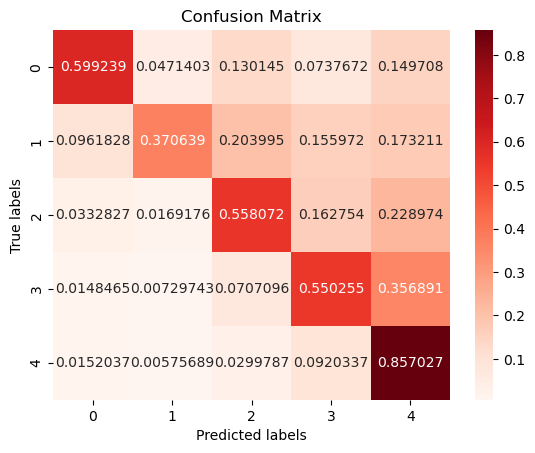

In [61]:
print("Accuracy on testing set = ", accuracy_score(y_train,y_pred))
print("RMSE on testing set = ", mean_squared_error(y_train,y_pred))

ax= plt.subplot()
cm=confusion_matrix(y_train,y_pred,normalize='true')
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

In [21]:
estimators=[('LinearSVC', model),('logistic_regression', model2)]
voting = VotingClassifier(estimators, voting='soft')
voting.fit(X_train, y_train)

RMSE on testing set =  0.7317876344086022


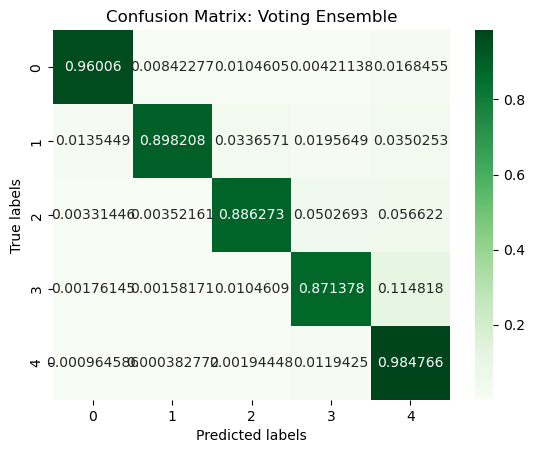

In [97]:
ensemble_predictions=voting.predict(X_train)
ax= plt.subplot()

print("RMSE on testing set = ", mean_squared_error(y_train, ensemble_predictions))

cm=confusion_matrix(y_train, ensemble_predictions, normalize='true')
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');  
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix: Voting Ensemble');

## Create the Kaggle submission

In [41]:
Y_test_predictions = voting.predict(X_test)
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score'])

X_submission['Score'] = Y_test_predictions
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

Now you can upload the `submission.csv` to kaggle